In [1]:
import vowpal_wabbit_next as vw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from typing import List, Tuple

In [2]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [3]:
def get_cost(context, action):
    '''
    Tom prefers politics in the morning and music in the afternoon, 
    while Anna enjoys sports in the morning and politics later; 
    the dense reward function simulates this in a format the 
    learner recognizes as cost, rewarding article recommendations 
    that match preferences with a simulated "click."
    '''
    if context["user"] == "Tom":
        if context["time_of_day"] == "morning" and action == "politics":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "music":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context["user"] == "Anna":
        if context["time_of_day"] == "morning" and action == "sports":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "politics":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [4]:
def parse_lines(parser: vw.TextFormatParser, input_str: str) -> List[vw.Example]:
    return [parser.parse_line(line) for line in input_str.split("\n")]

In [5]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(
        context["user"], context["time_of_day"]
    )
    
    # import pdb; pdb.set_trace()

    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    # Strip the last newline
    # import pdb; pdb.set_trace()
    return example_string[:-1]

In [6]:
context = {
    "user": "Tom", 
    "time_of_day": "morning"
}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context, actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [7]:
def sample_custom_pmf(pmf: List[Tuple[int, float]]) -> Tuple[int, float]:
    values = [x for (_, x) in pmf]
    total = sum(values)
    scale = 1 / total
    values = [x * scale for x in values]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(values):
        sum_prob += prob
        if sum_prob > draw:
            return pmf[index][0], prob

In [8]:
def get_action(workspace: vw.Workspace, parser: vw.TextFormatParser, context, actions):
    pmf = workspace.predict_one(
        parse_lines(parser, to_vw_example_format(context, actions))
    )
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [9]:
users = ["Tom", "Anna"]
times_of_day = ["morning", "afternoon"]
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]


def choose_user(users):
    return random.choice(users)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)


# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({"users": users, "times_of_day": times_of_day, "actions": actions})
    df["cost"] = df.apply(
        lambda r: cost_fun({"user": r[0], "time_of_day": r[1]}, r[2]), axis=1
    )

    return df.pivot_table(
        index=["users", "times_of_day"], columns="actions", values="cost"
    )

In [10]:
get_preference_matrix(get_cost)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In [11]:
def run_simulation(
    workspace: vw.Workspace,
    num_iterations,
    users,
    times_of_day,
    actions,
    cost_function,
    do_learn=True,
):
    cost_sum = 0.0
    ctr = []

    text_parser = vw.TextFormatParser(workspace)

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {"user": user, "time_of_day": time_of_day}
        action, prob = get_action(workspace, text_parser, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = to_vw_example_format(context, actions, (action, cost, prob))
            # 6. Learn
            workspace.learn_one(parse_lines(text_parser, vw_format))

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1 * cost_sum / i)

    return ctr


In [12]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("ctr", fontsize=14)
    plt.ylim([0, 1])


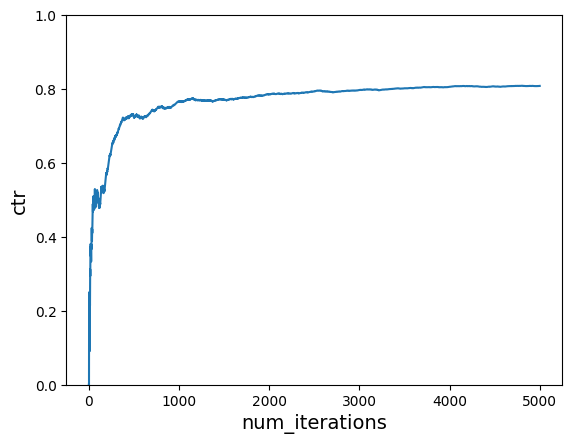

In [13]:
# Instantiate learner in VW
workspace = vw.Workspace(["--cb_explore_adf", "--interactions=UA", "--epsilon=0.2"])

num_iterations = 5000
ctr = run_simulation(workspace, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)